In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import seaborn as sn
import matplotlib.pyplot as plt
traindata_raw = pd.read_csv('au_train.csv')
testdata_raw = pd.read_csv('au_test.csv')
traindata_raw=traindata_raw.rename(columns={"class":"income"})
testdata_raw=testdata_raw.rename(columns={"class":"income"})
traindata=traindata_raw.dropna(axis=0)
testdata=testdata_raw.dropna(axis=0)

In [2]:
columname = traindata.columns
traindata=np.array(traindata)
testdata=np.array(testdata)

for i in range(1,np.shape(traindata)[1]):
     traindata = traindata[traindata[:,i]!=' ?']
traindata=pd.DataFrame(traindata)
traindata.columns=columname

for i in range(1,np.shape(testdata)[1]):
     testdata = testdata[testdata[:,i]!=' ?']
testdata=pd.DataFrame(testdata)
testdata.columns=columname

#### feature manipulation - based some of it on segmentation study

In [3]:
traindata = traindata.infer_objects()
testdata=testdata.infer_objects()
testdata['capital-net']=testdata['capital-gain']-testdata['capital-loss']
traindata['capital-net']=traindata['capital-gain']-traindata['capital-loss']
testdata['income'].replace({" <=50K.": 0, " >50K.": 1}, inplace=True)
traindata['income'].replace({" <=50K": 0, " >50K": 1}, inplace=True)
testdata['sex'] = np.where(testdata.sex == ' Male',1,0)
traindata['sex'] = np.where(traindata.sex == ' Male',1,0)
testdata['native-country'] = np.where(testdata['native-country'] == ' United-States',1,0)
traindata['native-country'] = np.where(traindata['native-country'] == ' United-States',1,0)
testdata['workclass'] = np.where(testdata.workclass == ' Private',1,0)
traindata['workclass'] = np.where(traindata.workclass == ' Private',1,0)
testdata['race_other'] = np.where((testdata.race != ' Black')&(testdata.race != ' White'),1,0)
testdata['race_black'] = np.where(testdata.race == ' Black',1,0)
testdata['race_white'] = np.where(testdata.race == ' White',1,0)
traindata['race_other'] = np.where((traindata.race != ' Black')&(traindata.race != ' White'),1,0)
traindata['race_black'] = np.where(traindata.race == ' Black',1,0)
traindata['race_white'] = np.where(traindata.race == ' White',1,0)

#### dropping some columns below

In [4]:
Xtest=testdata.drop(columns=['income','education-num','capital-gain','capital-loss','race','native-country','workclass'])
Xtrain=traindata.drop(columns=['income','education-num','capital-gain','capital-loss','race','native-country','workclass'])

In [5]:
ytrain=traindata.income
ytest=testdata.income
Xtrain_cont=Xtrain.select_dtypes(exclude=['object'])
Xtest_cont=Xtest.select_dtypes(exclude=['object'])

#### code segment below was used to run a study using the One Hot encoder technique. Later I use Target Encoder technique instead.

In [6]:
#from sklearn.preprocessing import OneHotEncoder
#OHencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
#OHm_strain = pd.DataFrame(OHencoder.fit_transform(pd.DataFrame(Xtrain['marital-status'])))
#OHm_stest=pd.DataFrame(OHencoder.transform(pd.DataFrame(Xtest['marital-status'])))
#OHoctrain = pd.DataFrame(OHencoder.fit_transform(pd.DataFrame(Xtrain['occupation'])))
#OHoctest=pd.DataFrame(OHencoder.transform(pd.DataFrame(Xtest['occupation'])))
#OHrlntrain = pd.DataFrame(OHencoder.fit_transform(pd.DataFrame(Xtrain['relationship'])))
#OHrlntest=pd.DataFrame(OHencoder.transform(pd.DataFrame(Xtest['relationship'])))
#OHtrain_final = pd.concat([OHoctrain,OHrlntrain],axis=1,ignore_index=True)
#OHtest_final = pd.concat([OHoctest,OHrlntest],axis=1,ignore_index=True)
#Xtrain_final = pd.concat([Xtrain_cont,OHtrain_final],axis=1,ignore_index=False)
#Xtest_final = pd.concat([Xtest_cont,OHtest_final],axis=1,ignore_index=False)

In [7]:
import category_encoders as ce
object_col = ['occupation','marital-status','relationship','education']
targetencoder = ce.TargetEncoder(cols=object_col)
targetencoder.fit(Xtrain[object_col],ytrain)
Xtrain_final = Xtrain_cont.join(targetencoder.transform(Xtrain[object_col]))
Xtest_final = Xtest_cont.join(targetencoder.transform(Xtest[object_col]))

## Running various Classifier Models and Plotting confusion Matrix - also getting accuracy for each model

### Running Logistic Regression - Analysing the results using Confusion Matrix, Accuracy Score, AuC and RoC

Text(33.0, 0.5, 'True Val')

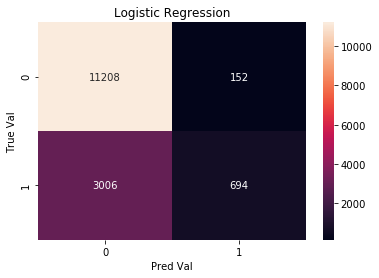

In [8]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=1)
lr_model.fit(Xtrain_cont, ytrain)
ymodel = lr_model.predict(Xtest_cont)
ytrained = lr_model.predict(Xtrain_cont)
lrcm = confusion_matrix(ytest, ymodel)
lrcm1 = pd.DataFrame(lrcm, index = [i for i in "01"], columns = [i for i in "01"])
ax1=plt.axes()
sn.heatmap(lrcm1,annot=True,ax=ax1,fmt="d")
ax1.set_title('Logistic Regression');ax1.set_xlabel('Pred Val'); ax1.set_ylabel('True Val')

In [9]:
accu1=accuracy_score(ytest, ymodel);accu1

0.7903054448871182

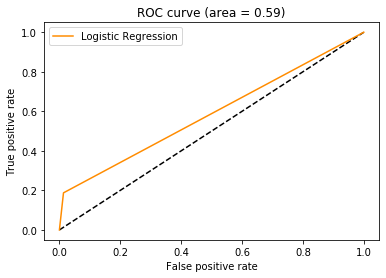

In [10]:
false_positive1, true_positive1, _ = roc_curve(ytest, ymodel)
auc1 = roc_auc_score(ytest, ymodel)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive1, true_positive1, color='darkorange', label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = %0.2f)' % auc1)
plt.legend(loc='best')
plt.show()

#### Running the model on training data set

Text(33.0, 0.5, 'True Val')

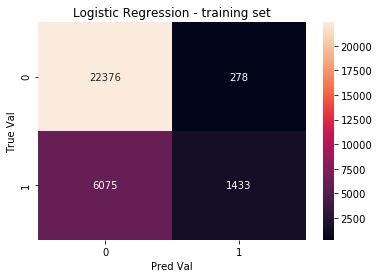

In [11]:
lrcm_t = confusion_matrix(ytrain, ytrained)
lrcmt_1 = pd.DataFrame(lrcm_t, index = [i for i in "01"], columns = [i for i in "01"])
ax1=plt.axes()
sn.heatmap(lrcmt_1,annot=True,ax=ax1,fmt="d")
ax1.set_title('Logistic Regression - training set');ax1.set_xlabel('Pred Val'); ax1.set_ylabel('True Val')

In [12]:
accu1t=accuracy_score(ytrain,ytrained);accu1t

0.7893707313838605

### Running Decision Tree Classifier - Analysing the results using Confusion Matrix, Accuracy Score, AuC and RoC

Text(33.0, 0.5, 'True Val')

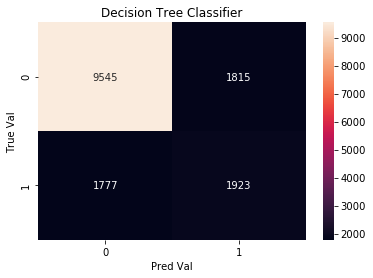

In [13]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(Xtrain_cont, ytrain)
ymodel = dt_model.predict(Xtest_cont)
ytrained = dt_model.predict(Xtrain_cont)
dtcm = confusion_matrix(ytest, ymodel)
dtcm1 = pd.DataFrame(dtcm, index = [i for i in "01"], columns = [i for i in "01"])
ax2=plt.axes()
sn.heatmap(dtcm1,annot=True,ax=ax2,fmt="d")
ax2.set_title('Decision Tree Classifier');ax2.set_xlabel('Pred Val'); ax2.set_ylabel('True Val')

In [14]:
accu2=accuracy_score(ytest, ymodel);accu2

0.7614873837981407

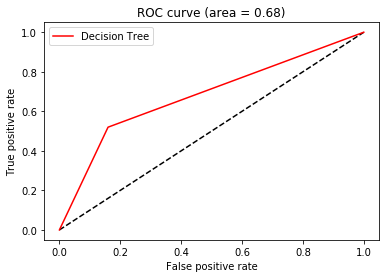

In [15]:
false_positive2, true_positive2, _ = roc_curve(ytest, ymodel)
auc2 = roc_auc_score(ytest, ymodel)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive2, true_positive2, color='red', label='Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = %0.2f)' % auc2)
plt.legend(loc='best')
plt.show()

#### Running the model on training data set

Text(33.0, 0.5, 'True Val')

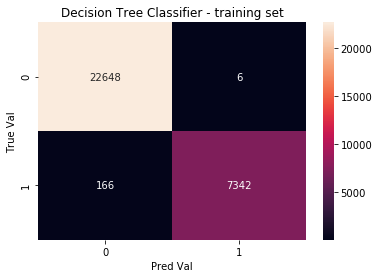

In [16]:
dtcm_t = confusion_matrix(ytrain, ytrained)
dtcmt_1 = pd.DataFrame(dtcm_t, index = [i for i in "01"], columns = [i for i in "01"])
ax2=plt.axes()
sn.heatmap(dtcmt_1,annot=True,ax=ax2,fmt="d")
ax2.set_title('Decision Tree Classifier - training set');ax2.set_xlabel('Pred Val'); ax2.set_ylabel('True Val')

In [17]:
accu2t=accuracy_score(ytrain, ytrained);accu2t

0.9942974603806114

### Running Random Forest Classifier - Analysing the results using Confusion Matrix, Accuracy Score, AuC and RoC

Text(33.0, 0.5, 'True Val')

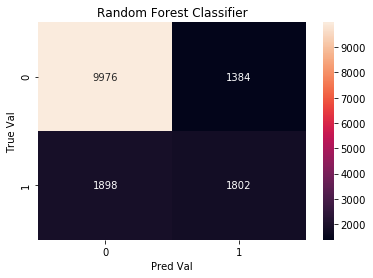

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(Xtrain_cont, ytrain)
ymodel = rf_model.predict(Xtest_cont)
ytrained = rf_model.predict(Xtrain_cont)
rfcm = confusion_matrix(ytest, ymodel)
rfcm1 = pd.DataFrame(rfcm, index = [i for i in "01"], columns = [i for i in "01"])
ax2=plt.axes()
sn.heatmap(rfcm1,annot=True,ax=ax2,fmt="d")
ax2.set_title('Random Forest Classifier');ax2.set_xlabel('Pred Val'); ax2.set_ylabel('True Val')

In [19]:
accu3=accuracy_score(ytest, ymodel);accu3

0.7820717131474103

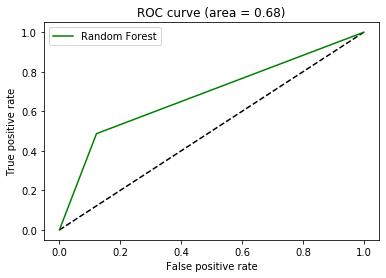

In [20]:
false_positive3, true_positive3, _ = roc_curve(ytest, ymodel)
auc3 = roc_auc_score(ytest, ymodel)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive3, true_positive3, color='green', label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = %0.2f)' % auc3)
plt.legend(loc='best')
plt.show()

#### Running the model on training data set

Text(33.0, 0.5, 'True Val')

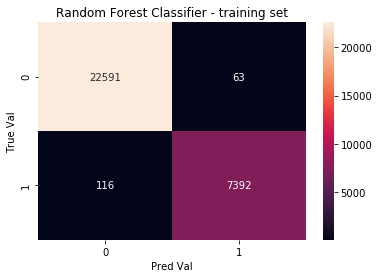

In [21]:
rfcm_t = confusion_matrix(ytrain, ytrained)
rfcmt_1 = pd.DataFrame(rfcm_t, index = [i for i in "01"], columns = [i for i in "01"])
ax2=plt.axes()
sn.heatmap(rfcmt_1,annot=True,ax=ax2,fmt="d")
ax2.set_title('Random Forest Classifier - training set');ax2.set_xlabel('Pred Val'); ax2.set_ylabel('True Val')

In [22]:
accu3t=accuracy_score(ytrain, ytrained);accu3t

0.9940653802798223

### Running XGB Classifier - Analysing the results using Confusion Matrix, Accuracy Score, AuC and RoC

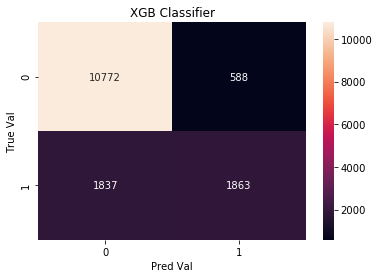

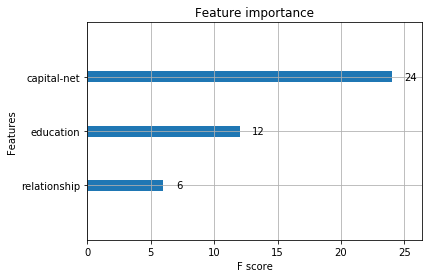

In [23]:
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from sklearn.model_selection import train_test_split
Xtrain_split, Xval, ytrain_split, yval = train_test_split(Xtrain_final, ytrain, random_state = 0)
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.01,random_state=1)
xgb_model.fit(Xtrain_split, ytrain_split, early_stopping_rounds=5, eval_set=[(Xval, yval)], verbose=False)
ymodel = xgb_model.predict(Xtest_final)
ytrained = xgb_model.predict(Xtrain_final)
xgbcm = confusion_matrix(ytest, ymodel)
xgbcm1 = pd.DataFrame(xgbcm, index = [i for i in "01"], columns = [i for i in "01"])
ax3=plt.axes()
sn.heatmap(xgbcm1,annot=True,ax=ax3,fmt="d")
ax3.set_title('XGB Classifier');ax3.set_xlabel('Pred Val'); ax3.set_ylabel('True Val')
plot_importance(xgb_model)

In [24]:
accu4=accuracy_score(ytest, ymodel);accu4

0.8389774236387783

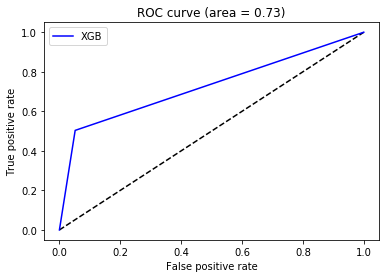

In [25]:
false_positive4, true_positive4, _ = roc_curve(ytest, ymodel)
auc4 = roc_auc_score(ytest, ymodel)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive4, true_positive4, color='blue', label='XGB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = %0.2f)' % auc4)
plt.legend(loc='best')
plt.show()

#### Running the model on training data set

Text(33.0, 0.5, 'True Val')

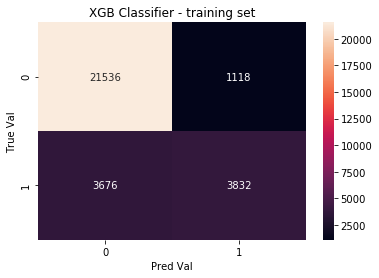

In [26]:
xgbcm_t = confusion_matrix(ytrain, ytrained)
xgbcm_t1 = pd.DataFrame(xgbcm_t, index = [i for i in "01"], columns = [i for i in "01"])
ax3=plt.axes()
sn.heatmap(xgbcm_t1,annot=True,ax=ax3,fmt="d")
ax3.set_title('XGB Classifier - training set');ax3.set_xlabel('Pred Val'); ax3.set_ylabel('True Val')

In [27]:
accu4t=accuracy_score(ytrain, ytrained);accu4t

0.8410582852595981

### Tuning up the XGB Classifier - Analysing the results using Confusion Matrix, Accuracy Score, AuC and RoC

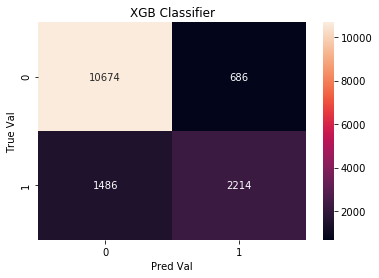

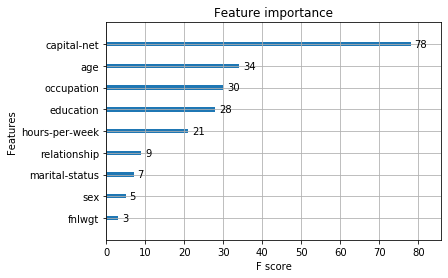

In [28]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
Xtrain_split, Xval, ytrain_split, yval = train_test_split(Xtrain_final, ytrain, random_state = 0)
xgb_model = XGBClassifier(n_estimators=1000, 
                          learning_rate=0.1,
                          random_state=1,
                          max_depth=5,
                          min_child_weight=5,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          gamma=0,
                          reg_alpha=2,
                          seed=4,
                          scale_pos_weight=1)
xgb_model.fit(Xtrain_split, ytrain_split, early_stopping_rounds=5, eval_set=[(Xval, yval)], verbose=False)
ymodel = xgb_model.predict(Xtest_final)
ytrained = xgb_model.predict(Xtrain_split)
xgbcm = confusion_matrix(ytest, ymodel)
xgbcm1 = pd.DataFrame(xgbcm, index = [i for i in "01"], columns = [i for i in "01"])
ax3=plt.axes()
sn.heatmap(xgbcm1,annot=True,ax=ax3,fmt="d")
ax3.set_title('XGB Classifier');ax3.set_xlabel('Pred Val'); ax3.set_ylabel('True Val')
plot_importance(xgb_model)

In [29]:
accu5=accuracy_score(ytest, ymodel);accu5

0.8557768924302789

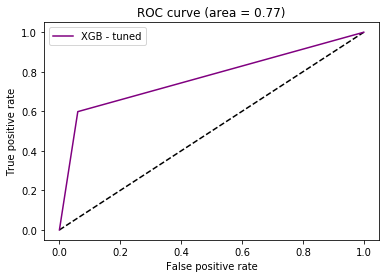

In [30]:
false_positive5, true_positive5, _ = roc_curve(ytest, ymodel)
auc5 = roc_auc_score(ytest, ymodel)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive5, true_positive5, color='purple', label='XGB - tuned')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = %0.2f)' % auc5)
plt.legend(loc='best')
plt.show()

#### running the tuned XGB model on training data set
_instead of tuning xgboost parameters manually - functions as xgboost CV and grid_search from Sklearn can be used to help tune the paratmeters further._

Text(33.0, 0.5, 'True Val')

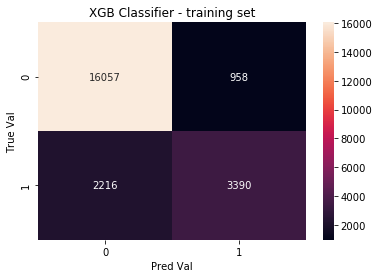

In [31]:
xgbcm_t = confusion_matrix(ytrain_split, ytrained)
xgbcm_t1 = pd.DataFrame(xgbcm_t, index = [i for i in "01"], columns = [i for i in "01"])
ax3=plt.axes()
sn.heatmap(xgbcm_t1,annot=True,ax=ax3,fmt="d")
ax3.set_title('XGB Classifier - training set');ax3.set_xlabel('Pred Val'); ax3.set_ylabel('True Val')

In [32]:
accu5t=accuracy_score(ytrain_split, ytrained);accu5t

0.8596879006233146

## Summarizing the results from all 5 models

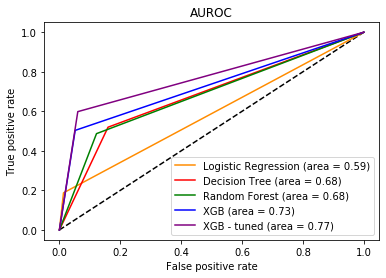

In [33]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive1, true_positive1, color='darkorange', label='Logistic Regression (area = %0.2f)' % auc1)
plt.plot(false_positive2, true_positive2, color='red', label='Decision Tree (area = %0.2f)' % auc2)
plt.plot(false_positive3, true_positive3, color='green', label='Random Forest (area = %0.2f)' % auc3)
plt.plot(false_positive4, true_positive4, color='blue', label='XGB (area = %0.2f)' % auc4)
plt.plot(false_positive5, true_positive5, color='purple', label='XGB - tuned (area = %0.2f)' % auc5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUROC')
plt.legend(loc='best')
plt.show()

In [34]:
modelresults = pd.DataFrame({'Model':['Logistic Regression','Decision Tree','Random Forest','XGB','XGB - tuned'],
                          'AUC':[auc1,auc2,auc3,auc4,auc5],
                          'Accuracy(test)':[accu1,accu2,accu3,accu4,accu5],
                          'Accuracy(training)':[accu1t,accu2t,accu3t,accu4t,accu5t]  }); modelresults

,Model,AUC,Accuracy(test),Accuracy(training)
0,Logistic Regression,0.587094,0.790305,0.789371
1,Decision Tree,0.679979,0.761487,0.994297
2,Random Forest,0.682598,0.782072,0.994065
3,XGB,0.725876,0.838977,0.841058
4,XGB - tuned,0.768996,0.855777,0.859688
